This notebook demonstrates how use the model api to run predictions and get information from the model. You can use it as basis to write your own experiements using the model in this container.

To start, import _modelapi.model_, which will give us access to the api of the model in this container.

In [1]:
from modelapi import model

In [13]:
# other helpful imports for this demo
import h5py
import json
import matplotlib.pyplot as plt
from dipy.io.image import load_nifti, save_nifti
import numpy as np

##### Various ways of handing data to the model

In [3]:
# You can either load the necessary input for the prediction from a file:
input = 'sample_data/sample.json'
# or assemble a dictionary for yourself 
input_dict = {"t1":{},"t2":{},"flair":{},"t1c":{}}
# mandatory: fileurl for each input!
input_dict["t1"]["fileurl"] = 'sample_data/patient_1/t1.nii.gz'
# mandatory: format for each input, be aware that this has to be a list:
input_dict["t1"]["format"] = ["application/nii-gzip"]
# and so on for each other input.. 

In [4]:
with open(input, "r") as f:
    input_dict_from_json = json.load(f)

In [6]:
# you can then simply pass your input to the model:
result = model.predict(input_dict_from_json)

loading checkpoint model/params/0/model_best.model train= False


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/contrib_src/predict.py:286: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  stacked = stacked[slicer]


loading checkpoint model/params/1/model_best.model train= False
loading checkpoint model/params/2/model_best.model train= False
loading checkpoint model/params/3/model_best.model train= False
loading checkpoint model/params/4/model_best.model train= False


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [18]:
# let's see what the output contains:
result

{'model': {'id': '14e79015-ae1d-49b7-9673-032f6e441d3d',
  'name': 'mic-dkfz-brats'},
 'output': [{'description': 'Numpy array of shape (240,240,155) with labels. Needs header from one of the input images to save to file.',
   'name': 'Segmentation',
   'prediction': 'api/output/2019-09-24-15-18-06-847454.h5',
   'shape': [155, 240, 240],
   'type': 'image'}],
 'processing_time': 25.019,
 'timestamp': '2019-09-24-15-18-06-851703'}

##### Recover a prediction from the h5 file

In [22]:
# recover prediction from h5 file
resultFile = result["output"][0]["prediction"].replace("api", "")
f = h5py.File(resultFile, 'r')
print(list(f.keys()))
# load the actual prediction and check for correct shape
prediction = f["Segmentation"]
print('Shape of prediction is: {}'.format(prediction.shape))

['Segmentation']
Shape of prediction is: (155, 240, 240)


1 0


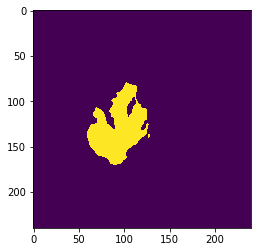

In [23]:
# just plot one slice to see if it returns a sensible result 
plt.imshow(prediction[90])
print(prediction[90].max(), prediction[90].min())

##### Saving the result as a Nifti-1 file so we can use it

In [24]:
# first, we have to swap the axes of the array to match the shape of the original images (155,240,240) -> (240,240,155)
prediction = np.swapaxes(prediction, 0,2)
# second, we load the metadata from one of the input images to populate the header:
affine = load_nifti('sample_data/patient_1/flair.nii.gz')[1]
save_nifti('sample_data/patient_1/segmentation.nii.gz', prediction, affine)

If the model does not provide any sample data, print an error message (this part also shows how to read meta info - like the model's name - from the models config).